In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from collections import defaultdict
from scipy.stats import iqr
from file_management_lib import get_paths, get_header
from lwa_lib import LWA
from cycler import cycler
from scipy.interpolate import CubicSpline
from scipy import interpolate
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from zeta_fit import get_linewidth
from scipy.optimize import curve_fit

import fit_functions as ff
import load_data as ld

import matplotlib.animation as animation


<>:64: SyntaxWarning: invalid escape sequence '\D'
<>:77: SyntaxWarning: invalid escape sequence '\D'
<>:64: SyntaxWarning: invalid escape sequence '\D'
<>:77: SyntaxWarning: invalid escape sequence '\D'
C:\Users\au617810\AppData\Local\Temp\ipykernel_8764\2807264427.py:64: SyntaxWarning: invalid escape sequence '\D'
  plt.text(-700, -15, '$\Delta f$ = 21 kHz \n $L = 700$ m', bbox=props, fontsize = 17)
C:\Users\au617810\AppData\Local\Temp\ipykernel_8764\2807264427.py:77: SyntaxWarning: invalid escape sequence '\D'
  plt.text(-12000, -15, '$\Delta f$ = 1.01 MHz \n $L = 30$ m', bbox=props, fontsize = 17)


375.11534852488705
1014164.6400329805
81018.07411156612
21719.963407378047


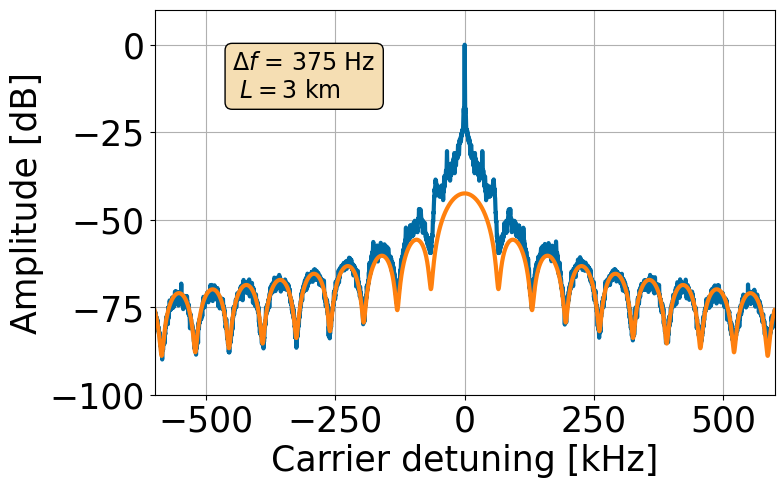

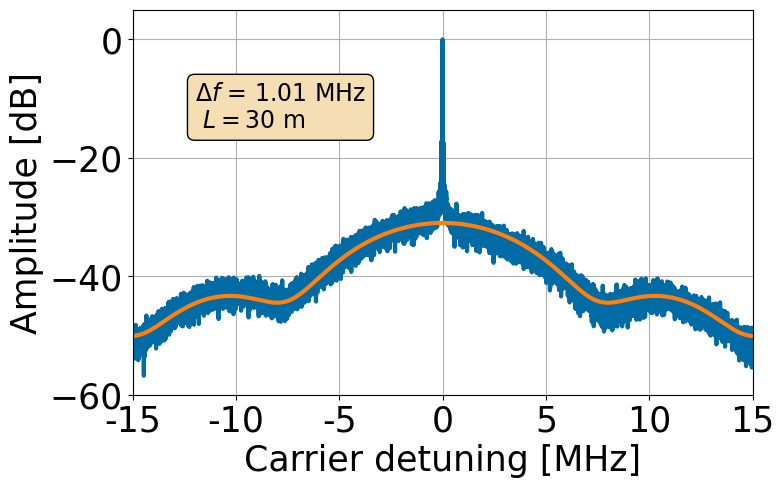

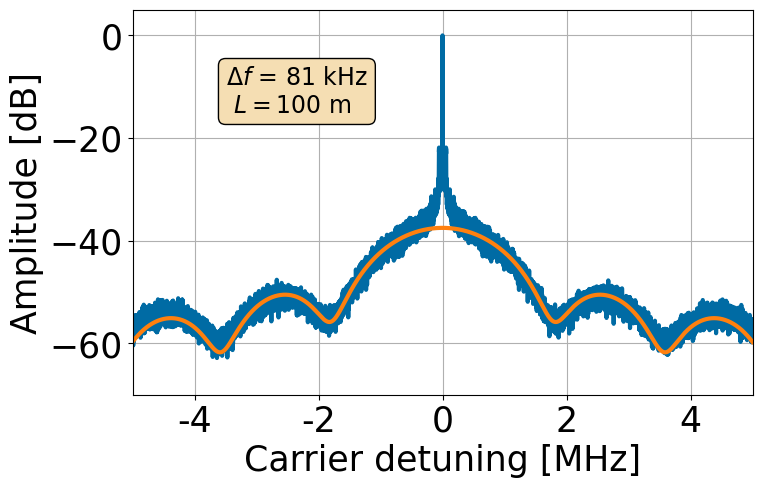

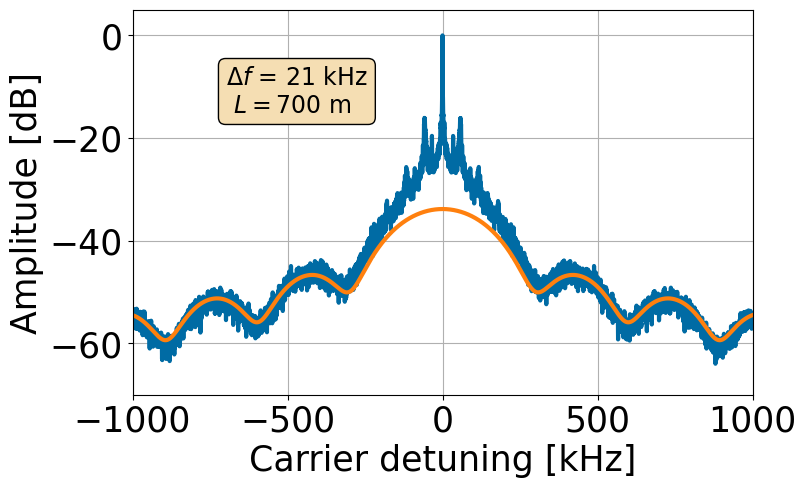

In [ ]:
plt.rcParams['axes.prop_cycle'] = cycler(color=['#006BA4','#FF800E', 'g', 'y','black','brown'])


path_30 = r"C:\Users\au617810\OneDrive - Aarhus universitet\Videnskabelig assistent\ECOC2025\Weird_data\Weird_data\200 counts"


lws = []

fontsize=25
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 9
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize

def plot_linewidth(path,delay=3000):
    df = pd.read_csv(path,header=2)
    
    freqs = df.values[:,0] - 76e6
    powers = df.values[:,1]

    
    linewidth, offset, length = get_linewidth(freqs, powers, delay, plot = True)
    plt.ylim([-100,10])
    plt.xlim([-600,600])
    return linewidth

def plot_special():

    lw = plot_linewidth(path)
    plt.xlabel('Carrier detuning [kHz]')
    plt.ylabel('Amplitude [dB]')
    plt.grid()
    
    #plt.legend(fontsize = 17)
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    plt.text(-450, -15, '$\\Delta f$ = 375 Hz \n $L = 3$ km', bbox=props, fontsize = 17)
    print(lw)

    
def plot_special_100():
    lw = plot_linewidth(path_100,delay=100)
    plt.xlabel('Carrier detuning [MHz]')
    plt.ylabel('Amplitude [dB]')
    plt.grid()
    plt.xlim([-5e3,5e3])
    plt.ylim([-70,5])
    plt.xticks([-4000,-2000,0,2000,4000],[-4,-2,0,2,4])
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    plt.text(-3500, -15, '$\\Delta f$ = 81 kHz \n $L = 100$ m', bbox=props, fontsize = 17)
    print(lw)

def plot_special_700():
    lw = plot_linewidth(path_700,delay=700)
    plt.xlabel('Carrier detuning [kHz]')
    plt.ylabel('Amplitude [dB]')
    plt.grid()
    plt.xlim([-1e3,1e3])
    plt.ylim([-70,5])
    #plt.legend(fontsize = 17)
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    plt.text(-700, -15, '$\Delta f$ = 21 kHz \n $L = 700$ m', bbox=props, fontsize = 17)
    print(lw)

def plot_special_30():
    lw = plot_linewidth(path_30,delay=30)
    plt.xlabel('Carrier detuning [MHz]')
    plt.ylabel('Amplitude [dB]')
    plt.grid()
    plt.xlim([-15e3,15e3])
    plt.ylim([-60,5])
    plt.xticks([-15000,-10000,-5000,0,5000,10000,15000],[-15,-10,-5,0,5,10,15])
    #plt.legend(fontsize = 17)
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)
    plt.text(-12000, -15, '$\Delta f$ = 1.01 MHz \n $L = 30$ m', bbox=props, fontsize = 17)
    print(lw)




plot_special()
plt.savefig(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\SPIE Prague 2025\Figures\Fit_3km.pdf",bbox_inches='tight')

plot_special_30()
plt.savefig(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\SPIE Prague 2025\Figures\Fit_30m.pdf",bbox_inches='tight')

plot_special_100()
plt.savefig(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\SPIE Prague 2025\Figures\Fit_100m.pdf",bbox_inches='tight')

plot_special_700()
plt.savefig(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\SPIE Prague 2025\Figures\Fit_700m.pdf",bbox_inches='tight')


In [17]:
#Coherence collapse linewidths

directory_40uW = r".\Data\coh_collapse\40uW"
directory_60uW = r".\Data\coh_collapse\60uW"
directory_80uW = r".\Data\coh_collapse\80uW"
directory_100uW = r".\Data\coh_collapse\100uW"

def gauss(x,a,b):
    """Gaussian in log scale base e"""
    return -0.5/np.log(10)*(x/a)**2 + b

def fit_spectrum(path,f_stop):
    df = pd.read_csv(path,header=2)
    
    freqs = df.values[:,0] - 76e6
    ps = df.values[:,1]
    filt = abs(freqs) < f_stop
    freqs_filt = freqs[filt]
    ps_filt = ps[filt]
    
    # plt.plot(freqs,ps)
    
    popt,_ = curve_fit(gauss,freqs_filt,ps_filt,p0=[1,-50])
    
    fwhm = popt[0]*2*np.sqrt(2*np.log(2))
    
    # plt.plot(freqs_filt,gauss(freqs_filt,*popt))
    # plt.ylim([-85,-50])
    # plt.xlim([-2*f_stop,2*f_stop])
    return fwhm

def IQR_filter(linewidths):
    Q1 = np.percentile(linewidths,25,method='midpoint')
    Q3 = np.percentile(linewidths,75,method='midpoint')
    iqr_number = iqr(linewidths, interpolation='midpoint')
    linewidths_filtered = []
    for linewidth in linewidths:
        if (linewidth < Q3+1.5*iqr_number and linewidth > Q1-1.5*iqr_number):
            linewidths_filtered.append(linewidth)
    return linewidths_filtered
 
def fit_all(directory,f_stop):
    linewidths = []
    for path in get_paths(directory):
        if 'txt' in path:
            fwhm = fit_spectrum(path,f_stop)
            linewidths.append(fwhm)
    linewidths_filtered = IQR_filter(linewidths)
    return linewidths, linewidths_filtered

def get_stats(data):
    print(np.mean(data), np.std(data))
    plt.figure()
    plt.plot(data,'.')

lw_40,lw_filtered_40 = fit_all(directory_40uW,f_stop=1e4)

lw_60,lw_filtered_60 = fit_all(directory_60uW,f_stop=1e5)

lw_80,lw_filtered_80 = fit_all(directory_80uW,f_stop=3e5)

lw_100,lw_filtered_100 = fit_all(directory_100uW,f_stop=1e6)


lw_40_mean = np.average(lw_filtered_40)
lw_40_std = np.std(lw_filtered_40)

lw_60_mean = np.average(lw_filtered_60)
lw_60_std = np.std(lw_filtered_60)

lw_80_mean = np.average(lw_filtered_80)
lw_80_std = np.std(lw_filtered_80)

lw_100_mean = np.average(lw_filtered_100)
lw_100_std = np.std(lw_filtered_100)

data = np.column_stack([[8400,8400,8400,8400],[40,60,80,100],[lw_40_mean,lw_60_mean,lw_80_mean,lw_100_mean],[lw_40_std,lw_60_std,lw_80_std,lw_100_std]])

np.savetxt(r'.\Data\coh_collapse\coh_collapse_data.txt',data, delimiter=",", fmt="%s", header="Output power [µW],\tFB ratios (dB),\tAvg linewidth (Hz),\tStandard deviation of linewidth")


In [18]:
## Obtain linewidths from SCELD method, load data
def path(file,directory):
    return directory + '\\' + file


data_dir1 = r".\Data\Linewidth_SCELD"



# data_dirs = [path(file,data_dir1) for file in os.listdir(data_dir1)]

data_dirs=[data_dir1]

datasets_no = len(data_dirs)# len(data_dirs)

dirs= [None for _ in range(datasets_no)]

for i in range(1):
    # print(data_dirs[i])
    dirs[i] = ld.get_SMSR_filtered_data(data_dirs[i])

['.\\Data\\Linewidth_SCELD\\2024-07-16_15-55-47_fb_900µW', '.\\Data\\Linewidth_SCELD\\2024-07-16_15-59-18_fb_300µW', '.\\Data\\Linewidth_SCELD\\2024-07-16_17-34-53_fb_690.3µW', '.\\Data\\Linewidth_SCELD\\2024-07-16_18-07-20_fb_100.8µW', '.\\Data\\Linewidth_SCELD\\2024-07-16_19-08-33_fb_50.8µW', '.\\Data\\Linewidth_SCELD\\2024-07-16_19-17-07_fb_30.4µW', '.\\Data\\Linewidth_SCELD\\2024-07-17_10-35-01_fb_15.0µW', '.\\Data\\Linewidth_SCELD\\2024-07-17_10-52-38_fb_10.37µW', '.\\Data\\Linewidth_SCELD\\2024-07-17_11-09-03_fb_5.3µW', '.\\Data\\Linewidth_SCELD\\2024-07-17_11-18-35_fb_2.5µW', '.\\Data\\Linewidth_SCELD\\2024-07-17_11-26-07_fb_1.03µW', '.\\Data\\Linewidth_SCELD\\2024-07-17_11-39-05_fb_0.253µW', '.\\Data\\Linewidth_SCELD\\2024-07-17_12-24-55_fb_0.501µW', '.\\Data\\Linewidth_SCELD\\2024-07-17_12-36-20_fb_0.0521µW', '.\\Data\\Linewidth_SCELD\\2024-07-17_12-49-15_fb_0.1018µW', '.\\Data\\Linewidth_SCELD\\2024-07-17_12-51-23_fb_0.0252µW', '.\\Data\\Linewidth_SCELD\\2024-07-17_12-55-44_f

In [19]:
def get_smsr(fs, ps, center, fsr, plot = False):
    sideband1 = center - fsr
    sideband2 = center + fsr

    filter1 = abs(fs - sideband1) < 1
    ps1 = ps[filter1]
    fs1 = fs[filter1]

    filter2 = abs(fs - sideband2) < 1
    ps2 = ps[filter2]
    fs2 = fs[filter2]

    filter3 = abs(fs - center) < 1
    ps3 = ps[filter3]
    fs3 = fs[filter3]

    if plot:
        plt.plot(fs,ps)
    return max(ps3) - max([max(ps1),max(ps2)])


def ratio_to_dB(numerator,denominator):
    return 10*np.log10(numerator/denominator)

In [20]:
## Obtain linewidths from SCELD method, get parameters, and fit to get linewidth


measurements = [[[None for _ in range(len(dirs[ds_no][fb_meas_index][2])) ] for fb_meas_index in range(len(dirs[ds_no]))] for ds_no in range(datasets_no)]
delays = [[None for _ in range(len(dirs[ds_no]))] for ds_no in range(datasets_no)]


for data_index in range(datasets_no):
    #fig, ax = plt.subplots()
    #artists = []

    #if data_index < 3:

    for fb_meas_index in range(len(dirs[data_index])):
        for i, directory in enumerate(dirs[data_index][fb_meas_index][2]): #Close spectrum is index 2
            
            if directory == None:
                pass
            else:
                fs = directory.freqs #Obtaining ESA close spectrum frequencies
                ps = directory.powers #Obtaining ESA close spectrum powers

                plot = False
            
                #fs, ps = dp.get_close_spectrum_from_folder(directory,plot=plot,center_about_carrier=True)

                measurements[data_index][fb_meas_index][i] = fs, ps

                if plot:
                        
                    plt.figure()
                    plt.plot(fs,ps)
                    plt.xlim([-0.6,0.6])
                    plt.ylim([-120,-40])
                    plt.xlabel('Frequency detuning [MHz]')
                    plt.ylabel('Spectrum power [dBc]')
                    plt.title(f'Plot number {i}')
                    
        delays[data_index][fb_meas_index] = dirs[data_index][fb_meas_index][6][' Delay']



linewidths = [[[None for _ in range(len(dirs[ds_no][fb_meas_index][2])) ] for fb_meas_index in range(len(dirs[ds_no]))] for ds_no in range(datasets_no)]

smsrs = [[[None for _ in range(len(dirs[ds_no][fb_meas_index][2])) ] for fb_meas_index in range(len(dirs[ds_no]))] for ds_no in range(datasets_no)]

fit_settings = {3000 : [0.2, 0.5, 1e3],
        700 : [0.2, 1, 3e4],
        100 : [0.2, 3, 1e5],
        30 : [0.2, 10, 3e5]}


for data_index in range(datasets_no):
    #fig, ax = plt.subplots()
    #artists = []

    #if data_index < 3:

    for fb_meas_index in range(len(dirs[data_index])):

        delay_length = delays[data_index][fb_meas_index]

        settings = fit_settings[delay_length]

        filter = (abs(fs) > settings[0]) & (abs(fs) < settings[1])

        lw_guess = settings[2]


        for i, directory in enumerate(dirs[data_index][fb_meas_index][2]): #Close spectrum is index 2
            
            #fs, ps = dp.get_close_spectrum_from_folder(dirs[i],plot=False,center_about_carrier=True)

            fs = measurements[data_index][fb_meas_index][i][0]
            ps = measurements[data_index][fb_meas_index][i][1] - max(measurements[data_index][fb_meas_index][i][1])


            filter = (abs(fs) > settings[0]) & (abs(fs) < settings[1])


            try:
                params, whatevs = curve_fit(ff.zeta_fit,fs[filter]*10**6,ps[filter],p0=[lw_guess,11,delay_length])#,bounds=((lw_guess/5e2,-100,delay_length*0.9),(lw_guess*5e1,100,delay_length*1.1)))
            except RuntimeError:
                params = [1e9,11,delay_length]
                # print(f'Fit failed, delay={delay_length} Data_index={data_index}, fb_meas_index={fb_meas_index},no{i}')
                # plt.figure()
                # plt.plot(fs,ps, label = 'data')
                # plt.title(f'Data_index={data_index}, fb_meas_index={fb_meas_index},no{i}, 1 GHz linewidth')

            linewidths[data_index][fb_meas_index][i] = params[0]


            fs_full = dirs[data_index][fb_meas_index][1][i].freqs 
            ps_full = dirs[data_index][fb_meas_index][1][i].powers
            # plt.figure()
            # plt.plot(fs_full,ps_full)

            smsrs[data_index][fb_meas_index][i] = get_smsr(fs_full,ps_full,76,11.7)

            # plt.figure()
            # plt.plot(fs,ps, label = 'Data, background subtracted')
            # plt.plot(fs,ff.zeta_fit(fs*10**6,params[0],params[1],params[2]), label = 'zeta function')
            # plt.title(f'{data_dirs[data_index][-10:]}  no. {i}, Linewidth: {params[0]*1e-3:.1f} kHz, feedback ratio: {feedback_ratio:.2f} dB, Laser power: {laser_power:.0f} µW')
            # plt.legend()

            # plt.xlim([-10,10])
            # plt.ylim([-100,0])


o:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\Zenodo\fit_functions.py:81: RuntimeWarning: invalid value encountered in log10
  return 10*np.log10(zeta_func(freq,linewidth,time_delay(length)))+offset
c:\Users\au617810\.conda\envs\conda_env\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


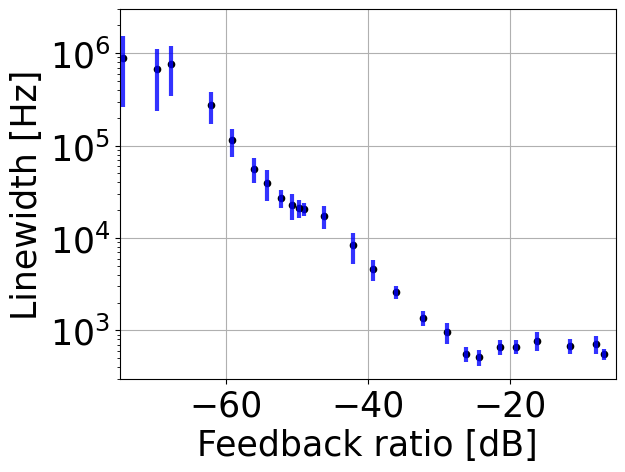

In [21]:
folder_feedback = []
folder_power = []
fb_ratios = []
for folder in os.listdir(data_dir1):
    if 'fb' not in folder:
        path = data_dir1 + '//' + folder
        file_path = os.listdir(path)[0]
        header_list = get_header(path+'//'+file_path,4)

        fb = float(header_list[2][2])
        pow = float(header_list[1][2])
        
        folder_feedback.append(fb)
        folder_power.append(pow)

        fb_ratios.append(ratio_to_dB(fb,pow))
        
for data_index in range(datasets_no):
    for fb_meas_index in range(len(dirs[data_index])):
       
        
        if sum(np.array(linewidths[data_index][fb_meas_index])!=None) > 3: #Outlier sorting doesn't work for n<=3, so only take datasets with 4 datapoints or more.
            linewidths_filtered = IQR_filter(linewidths[data_index][fb_meas_index])
            plt.figure(1)
            plt.plot(fb_ratios[fb_meas_index],np.average(np.array(linewidths_filtered)),'.k')
            plt.errorbar((fb_ratios[fb_meas_index]),np.average(np.array(linewidths_filtered)),yerr=np.std(np.array(linewidths_filtered)),color='b',alpha=0.8)
    plt.yscale('log')
    plt.xlabel('Feedback ratio [dB]')
    plt.ylabel('Linewidth [Hz]')
    plt.ylim([3e2,3e6])
    plt.xlim([-75,-5])

    plt.grid()

    plt.figure(1)
    plt.yscale('log')
    plt.xlabel('Feedback ratio [dB]')
    plt.ylabel('Linewidth [Hz]')


In [22]:
## Obtain linewidths from SCELD method for various wavelengths
def path(file,directory):
    return directory + '\\' + file


data_dir2 = r".\Data\Wavelength_linewidth"

# data_dirs = [path(file,data_dir1) for file in os.listdir(data_dir1)]

data_dirs=[data_dir2]

datasets_no = len(data_dirs)# len(data_dirs)

dirs= [None for _ in range(datasets_no)]

for i in range(1):
    print(data_dirs[i])
    dirs[i] = ld.get_SMSR_filtered_data(data_dirs[i])

.\Data\Wavelength_linewidth
['.\\Data\\Wavelength_linewidth\\2024-07-23_10-19-44_fb_1513', '.\\Data\\Wavelength_linewidth\\2024-07-23_12-06-05_fb_1518', '.\\Data\\Wavelength_linewidth\\2024-07-23_13-39-20_fb_1523', '.\\Data\\Wavelength_linewidth\\2024-07-23_13-56-23_fb_1527', '.\\Data\\Wavelength_linewidth\\2024-07-23_14-04-06_fb_1533', '.\\Data\\Wavelength_linewidth\\2024-07-23_14-10-37_fb_1537', '.\\Data\\Wavelength_linewidth\\2024-07-23_14-21-00_fb_1542', '.\\Data\\Wavelength_linewidth\\2024-07-23_14-50-14_fb_1547', '.\\Data\\Wavelength_linewidth\\2024-07-23_15-58-03_fb_1549', '.\\Data\\Wavelength_linewidth\\2024-07-23_16-19-49_fb_1555']
.\Data\Wavelength_linewidth\2024-07-23_10-19-44_fb_1513
.\Data\Wavelength_linewidth\2024-07-23_12-06-05_fb_1518
.\Data\Wavelength_linewidth\2024-07-23_13-39-20_fb_1523
.\Data\Wavelength_linewidth\2024-07-23_13-56-23_fb_1527
.\Data\Wavelength_linewidth\2024-07-23_14-04-06_fb_1533
.\Data\Wavelength_linewidth\2024-07-23_14-10-37_fb_1537
.\Data\Waveleng

In [23]:
measurements = [[[None for _ in range(len(dirs[ds_no][fb_meas_index][2])) ] for fb_meas_index in range(len(dirs[ds_no]))] for ds_no in range(datasets_no)]
delays = [[None for _ in range(len(dirs[ds_no]))] for ds_no in range(datasets_no)]

for data_index in range(datasets_no):
    #fig, ax = plt.subplots()
    #artists = []

    #if data_index < 3:

    for fb_meas_index in range(len(dirs[data_index])):
        for i, directory in enumerate(dirs[data_index][fb_meas_index][2]): #Close spectrum is index 2
            
            if directory == None:
                pass
            else:
                fs = directory.freqs #Obtaining ESA close spectrum frequencies
                ps = directory.powers #Obtaining ESA close spectrum powers

                plot = False
            
                #fs, ps = dp.get_close_spectrum_from_folder(directory,plot=plot,center_about_carrier=True)

                measurements[data_index][fb_meas_index][i] = fs, ps

                if plot:
                        
                    plt.figure()
                    plt.plot(fs,ps)
                    plt.xlim([-0.6,0.6])
                    plt.ylim([-120,-40])
                    plt.xlabel('Frequency detuning [MHz]')
                    plt.ylabel('Spectrum power [dBc]')
                    plt.title(f'Plot number {i}')
                    
    
        delays[data_index][fb_meas_index] = dirs[data_index][fb_meas_index][6][' Delay']



linewidths = [[[None for _ in range(len(dirs[ds_no][fb_meas_index][2])) ] for fb_meas_index in range(len(dirs[ds_no]))] for ds_no in range(datasets_no)]

smsrs = [[[None for _ in range(len(dirs[ds_no][fb_meas_index][2])) ] for fb_meas_index in range(len(dirs[ds_no]))] for ds_no in range(datasets_no)]

fit_settings = {3000 : [0.2, 0.5, 1e3],
        700 : [0.2, 1, 3e4],
        100 : [0.2, 3, 1e5],
        30 : [0.2, 10, 3e5]}


for data_index in range(datasets_no):
    #fig, ax = plt.subplots()
    #artists = []

    #if data_index < 3:

    for fb_meas_index in range(len(dirs[data_index])):

        delay_length = delays[data_index][fb_meas_index]

        settings = fit_settings[delay_length]

        filter = (abs(fs) > settings[0]) & (abs(fs) < settings[1])

        lw_guess = settings[2]


        for i, directory in enumerate(dirs[data_index][fb_meas_index][2]): #Close spectrum is index 2
            
            #fs, ps = dp.get_close_spectrum_from_folder(dirs[i],plot=False,center_about_carrier=True)

            fs = measurements[data_index][fb_meas_index][i][0]
            ps = measurements[data_index][fb_meas_index][i][1] - max(measurements[data_index][fb_meas_index][i][1])


            filter = (abs(fs) > settings[0]) & (abs(fs) < settings[1])


            try:
                params, whatevs = curve_fit(ff.zeta_fit,fs[filter]*10**6,ps[filter],p0=[lw_guess,11,delay_length])#,bounds=((lw_guess/5e2,-100,delay_length*0.9),(lw_guess*5e1,100,delay_length*1.1)))
            except RuntimeError:
                params = [1e9,11,delay_length]
                # print(f'Fit failed, delay={delay_length} Data_index={data_index}, fb_meas_index={fb_meas_index},no{i}')
                # plt.figure()
                # plt.plot(fs,ps, label = 'data')
                # plt.title(f'Data_index={data_index}, fb_meas_index={fb_meas_index},no{i}, 1 GHz linewidth')

            linewidths[data_index][fb_meas_index][i] = params[0]


            fs_full = dirs[data_index][fb_meas_index][1][i].freqs 
            ps_full = dirs[data_index][fb_meas_index][1][i].powers
            # plt.figure()
            # plt.plot(fs_full,ps_full)

            smsrs[data_index][fb_meas_index][i] = get_smsr(fs_full,ps_full,76,11.7)




            # plt.figure()
            # plt.plot(fs,ps, label = 'Data, background subtracted')
            # plt.plot(fs,ff.zeta_fit(fs*10**6,params[0],params[1],params[2]), label = 'zeta function')
            # plt.title(f'{data_dirs[data_index][-10:]}  no. {i}, Linewidth: {params[0]*1e-3:.1f} kHz, feedback ratio: {feedback_ratio:.2f} dB, Laser power: {laser_power:.0f} µW')
            # plt.legend()

            # plt.xlim([-10,10])
            # plt.ylim([-100,0])


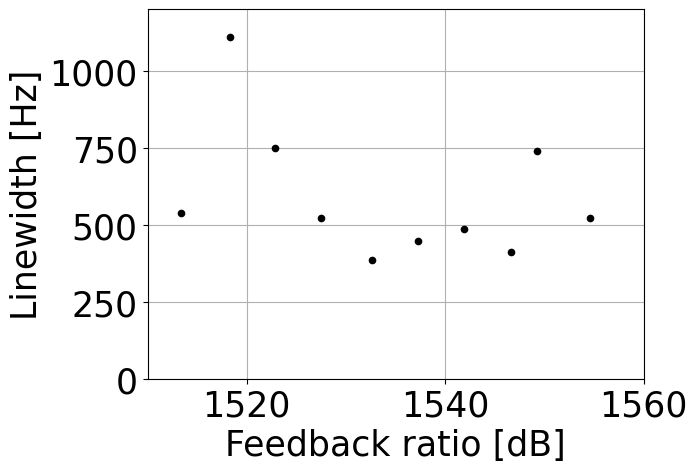

In [24]:
folder_feedback = []
folder_power = []
fb_ratios = []
wavelengths = []
for folder in os.listdir(data_dir2):
    if ('fb' not in folder) and ('.txt' not in folder):
        path = data_dir2 + '//' + folder
        for file in os.listdir(path):
            if 'result' in file:
                file_path = file
        header_list = get_header(path+'//'+file_path,5)

        fb = float(header_list[2][2])
        pow = float(header_list[1][2])
        
        folder_feedback.append(fb)
        folder_power.append(pow)

        wavelengths.append(float(header_list[3][1]))

        fb_ratios.append(ratio_to_dB(fb,pow))
        
for data_index in range(datasets_no):
    plt.figure(1)

    for fb_meas_index in range(len(dirs[data_index])):

        if sum(np.array(linewidths[data_index][fb_meas_index])!=None) > 3: #Outlier sorting doesn't work for n<=3, so only take datasets with 4 datapoints or more.
            linewidths_filtered = IQR_filter(linewidths[data_index][fb_meas_index])
            plt.plot(wavelengths[fb_meas_index],min(np.array(linewidths_filtered)),'.k')

        if abs(wavelengths[fb_meas_index]-1550)<1:
            lw = np.loadtxt(r".\Data\Wavelength_linewidth\2024-07-23_15-58-03_fb_1549\Min_linewidth_1549.txt")
            plt.plot(wavelengths[fb_meas_index],lw,'.k')


        elif abs(wavelengths[fb_meas_index]-1555)<1:
            lw = np.loadtxt(r".\Data\Wavelength_linewidth\2024-07-23_16-19-49_fb_1555\Min_linewidth_1555.txt")
            plt.plot(wavelengths[fb_meas_index],lw,'.k')



    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Linewidth [Hz]')
    plt.ylim([0,1200])
    plt.xlim([1510,1560])
    # plt.yscale('log')


    plt.grid()

    plt.figure(1)
    # plt.yscale('log')
    plt.xlabel('Feedback ratio [dB]')
    plt.ylabel('Linewidth [Hz]')

In [37]:
plt.style.library['tableau-colorblind10']

RcParams({'axes.prop_cycle': cycler('color', ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#5F9ED1', '#C85200', '#898989', '#A2C8EC', '#FFBC79', '#CFCFCF']),
          'patch.facecolor': '#006BA4'})

In [101]:
fontsize=27
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 9
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize


# Set a predefined color palette (e.g., 'tab10')
colors = plt.get_cmap('tab20').colors

# Use cycler to set the color palette globally
plt.rc('axes', prop_cycle=cycler('color', colors))

directory5 = r".\Data\Linewidth_SCELD"
directory6 = r".\Data\Wavelength_linewidth"

paths5 = []
paths6 = []

    
for dataset in get_paths(directory5):
    if ('fb' not in dataset) and ('.txt' not in dataset) and ('.csv' not in dataset) and ('.png' not in dataset) and ('Thumbs' not in dataset) and ('bad' not in dataset) and ('pdf' not in dataset):
        for path in get_paths(dataset):
            if 'result' in path:
                result = path
            paths5.append(result)

            
for dataset in get_paths(directory6):
    if ('fb' not in dataset) and ('.txt' not in dataset) and ('.csv' not in dataset) and ('.png' not in dataset) and ('Thumbs' not in dataset) and ('bad' not in dataset) and ('pdf' not in dataset):
        for path in get_paths(dataset):
            if 'result' in path:
                result = path
            if 'OSA' in path:
                osa = path
        paths6.append([result,osa])


def get_data2(path):
    df = pd.read_csv(path,header=3,
                     encoding="ISO-8859-1")
    linewidths = df.values[:,0]
    smsrs = df.values[:,1]
    
    header = get_header(path,length=3)
    feedback_power = float(header[2][2])
    delay = int(float(header[0][1]))
    
    return linewidths, feedback_power, delay

def get_data3(path):
    df = pd.read_csv(path,header=4,
                     encoding="ISO-8859-1",delimiter=',')
    linewidths = df.values[:,0]
    smsrs = df.values[:,1]
    
    header = get_header(path,length=4)
    output_power = float(header[1][2])
    feedback_power = float(header[2][2])
    delay = int(float(header[0][1]))
    wavelength = float(header[3][1])
    
    return linewidths, wavelength, output_power

def get_osa_data(path):
    df = pd.read_csv(path,header=3,
                     encoding="ISO-8859-1",delimiter=',')
    wavelengths = df.values[:,0]
    ps = df.values[:,1]
    ps_max = max(ps)
    if np.isnan(ps_max):
        ps_max = -9.53
    
    return wavelengths, ps - ps_max 

def linewidth_theory(feedback_power, nu_0, beta):
    tau = 1/(11e6)
    return nu_0 / (1 + tau*beta*np.sqrt(feedback_power))**2

powers = np.logspace(-10, 4, 1000)



def plot_dataset(paths):


    csh_data = np.loadtxt(r".\Data\Frequency_noise\csh_data.txt")
    
    csh_lws = csh_data[0]
    csh_std = csh_data[1]
    csh_fbs = csh_data[2]
    hf_lws = csh_data[3] 
    hf_std = csh_data[4]
    
    rin_data_loaded = np.loadtxt(r".\Data\RIN_MHz\RIN_integrated_vs_FB.txt",delimiter=",", dtype=str,skiprows=1)
    fb_powers_loaded = rin_data_loaded[:, 0].astype(float)  # Convert first column to float
    single_RIN_loaded = rin_data_loaded[:, 1].astype(float)  # Convert second column to float
    polarizations_loaded = rin_data_loaded[:, 2]

    rin_data = np.array([fb_powers_loaded,single_RIN_loaded,polarizations_loaded])

    
    ms = 14
    alpha1 = .6
    alpha2 = .9
    left_color = 'black'
    rin_color = 'black'
    dsh_color = "#C85200"  # Vivid Azure Blue
    csh_color = "#006BA4"  # Bright Magenta
    hf_color = "black"   # Balanced Bright Green
    
    output_power = 4200
    # fig, (ax,ax2)= plt.subplots(2,1,figsize=(18,11),gridspec_kw={'height_ratios': [5, 1]})
    fig, ax= plt.subplots(1,1,figsize=(18,11))# ,gridspec_kw={'height_ratios': [5, 1]})
    
    right_color = 'black'
    # ax2.set_ylabel('Integrated \n RIN [dB]', color=right_color)  # we already handled the x-label with ax1
    
    
    ax.grid()
    
    # ax2.tick_params(axis='y', labelcolor=right_color)
    
    # for (fb,rin,pol) in np.transpose(rin_data):
    #     if pol == 'misaligned':
    #         if float(fb) > -23:
    #             ax2.plot(float(fb),float(rin),'s', color=rin_color, markersize=ms-4,alpha=alpha2,label='Test')
    #     if pol == 'aligned':
    #         ax2.plot(float(fb),float(rin),'^', color=rin_color, markersize=ms-2,alpha=alpha1)
    
    ax.plot(10*np.log10(powers/output_power),linewidth_theory(powers,1811765.6561248302,8e8),'--',label='Theory',color='#595959')
    lw_floor= []
    fbs = []
    lw_mean = []
    lw_std = []
    
    ax.errorbar(csh_fbs[:3],csh_lws[:3],yerr=csh_std[:3],fmt='s',color=csh_color,markersize=ms-4,label='CSH',alpha=alpha2)
    ax.errorbar(csh_fbs[3:],csh_lws[3:],yerr=csh_std[3:],fmt='^',color=csh_color,markersize=ms,label='CSH',alpha=alpha1)
    ax.errorbar(csh_fbs[:3],hf_lws[:3],yerr=hf_std[:3],fmt='s',color=hf_color,markersize=ms-4,label='High Finesse',alpha=alpha2)
    ax.errorbar(csh_fbs[3:],hf_lws[3:],yerr=hf_std[3:],fmt='^',color=hf_color,markersize=ms,label='High Finesse',alpha=alpha1)
    
    for path in paths:
        linewidths, feedback_power, delay = get_data2(path)   
        color_dict = {30: 'blue',
                      100: 'red',
                      700: 'green',
                      3000: 'black'}
        
        linewidths_filtered = IQR_filter(linewidths)
        fb = 10*np.log10(feedback_power/output_power)
        fbs.append(fb)
        
        lw_mean.append(np.mean(linewidths_filtered))
        lw_std.append(np.std(linewidths_filtered))
        

        if fb < -24:
            ax.errorbar(fb, np.mean(linewidths_filtered), yerr = np.std(linewidths_filtered), fmt= '^', color = dsh_color,markersize=ms-2,alpha=alpha1)
        if fb > -24:
            ax.errorbar(fb, np.mean(linewidths_filtered), yerr = np.std(linewidths_filtered), fmt= 's', color = dsh_color,markersize=ms-4,alpha=1)
        
        if feedback_power > 10:
            lw_floor.append(np.mean(linewidths_filtered))
        ax.set(xscale='linear',
               yscale='log',
               xlabel='Feedback ratio [dB]',
               ylabel='Linewidth [Hz]',
               xlim=[-77,-5],
               ylim=[10,2e6],
               yticks=[1e1,1e2,1e3,1e4,1e5,1e6],
               yticklabels=[10,100,'1k','10k','100k','1M'],
               xticks=[-70,-60,-50,-40,-30,-20,-10])
        
        ax.set_ylabel('Intrinsic linewidth [Hz]',color=left_color)
        ax.tick_params(axis='y', labelcolor=left_color)
        
        # ax2.set(yticks=[-70,-60,-50,-40],
        #         ylim=[-77,-40],
        #         xlim=[-77,-5])
        # ax2.set_xlabel('')
        # ax2.grid(True)
    
    coh_collapse_data_loaded = np.loadtxt(r".\Data\coh_collapse\coh_collapse_data.txt",delimiter=",", dtype=str,skiprows=1)
    output_powers_loaded = np.array(coh_collapse_data_loaded[:, 0].astype(float))  # Convert first column to float
    fb_collapse = np.array(coh_collapse_data_loaded[:, 1].astype(float))  # Convert second column to float
    collapse_mean = coh_collapse_data_loaded[:, 2].astype(float)  # Convert second column to float
    collapse_std = coh_collapse_data_loaded[:, 3].astype(float)  # Convert second column to float

    fb_collapse = 10*np.log10(fb_collapse/(output_powers_loaded))
    
    
    ax.errorbar(fb_collapse, collapse_mean, yerr = collapse_std, fmt= '^', color = dsh_color,markersize=ms-2,alpha=alpha1)
    # Create a spline interpolation
    #print(np.insert(fb_collapse,0, fbs[8]))
    x = np.insert(fb_collapse,0, fbs[7])
    y = np.insert(collapse_mean,0,lw_mean[7])
    spline = CubicSpline(x,y)
    
    ax.axvline(-24,linestyle='-',color='#ABABAB',alpha=0.8,linewidth=4)
    # ax2.axvline(-24,linestyle='-',color='blue',alpha=0.2,linewidth=4)
    
    custom_handles = [
    mlines.Line2D([], [], color=dsh_color, marker='^',alpha=alpha1,linestyle='None',markersize=ms-2, label='SCELD: Aligned pol.'),
    mlines.Line2D([], [], color=dsh_color, marker='s',alpha=alpha2, linestyle='None',markersize=ms-4, label='SCELD: Misaligned pol.'),
    mlines.Line2D([], [], color=csh_color, marker='^',alpha=alpha1, linestyle='None',markersize=ms-2, label='CSH: Aligned pol.'),
    mlines.Line2D([], [], color=csh_color, marker='s',alpha=alpha2, linestyle='None',markersize=ms-4, label='CSH: Misaligned pol.'),
    mlines.Line2D([], [], color=hf_color, marker='^',alpha=alpha1, linestyle='None',markersize=ms-2, label='FNA: Aligned pol.'),
    mlines.Line2D([], [], color=hf_color, marker='s',alpha=alpha2, linestyle='None',markersize=ms-4, label='FNA: Misaligned pol.'),
    mlines.Line2D([], [], color='#595959', linestyle='--',markersize=ms-4, label='Theory')
   ]
    
    custom_handles2 = [
    mlines.Line2D([], [], color=rin_color, marker='^',alpha=alpha1,linestyle='None',markersize=ms-2, label='Aligned pol.'),
    mlines.Line2D([], [], color=rin_color, marker='s',alpha=alpha2, linestyle='None',markersize=ms-4, label='Misaligned pol.'),
   ]
    
    fs =24
    ax.legend(handles=custom_handles,fontsize=fs,loc=(.02,.02),framealpha=.8)
    # ax2.legend(handles=custom_handles2,fontsize=fs,loc='upper left',ncols=2,framealpha=.8)
    
    
    
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    # plt.savefig(r".\linewidth_vs_feedback.pdf", bbox_inches = 'tight')   
    
    return fbs,lw_mean,lw_std


def plot_wavelengths(paths):
    plt.style.use('tableau-colorblind10')

    fig, (ax,ax2) = plt.subplots(2,1,figsize=(10,7),sharex='all')
    linewidths_total = []
    wavelengths_total = []
    for path, osa in paths:
        linewidths, wavelength, output_power = get_data3(path)  

        linewidths_total.append(linewidths)
        wavelengths_total.append(wavelength)

        linewidths_filtered = IQR_filter(linewidths)
        if abs(wavelength - 1549) < 1:
            ax.plot(wavelength,738,'.',markersize=10,color='black')
        elif abs(wavelength - 1555) < 1:
            ax.plot(wavelength,521,'.',markersize=10,color='black')
        else:
            ax.plot(wavelength,min(linewidths_filtered),'.',markersize=10,color='black')
        linewidths_filtered = IQR_filter(linewidths)
        wavelengths, powers = get_osa_data(osa)
        
        ax2.plot(wavelengths,powers,alpha=1)
        
        ax.set(xscale='linear',
               yscale='linear',
               xlabel='Wavelength [nm]',
               ylabel='Min. linewidth \n [Hz]',
               ylim=[0,1200],
               xlim=[1510,1558],
               yticks=[0,500,1000])
        ax2.set(ylim=[-60,10],
                ylabel='Power [dB]')
        
    
    spacing = 5
    minorLocator = MultipleLocator(spacing)

    ax.xaxis.set_minor_locator(minorLocator)
    ax.grid(which='both')

    ax2.grid(which='both')
    # plt.savefig(r".\linewidth_vs_wavelength.pdf", bbox_inches = 'tight') 
    # 
    return linewidths_total,wavelengths_total

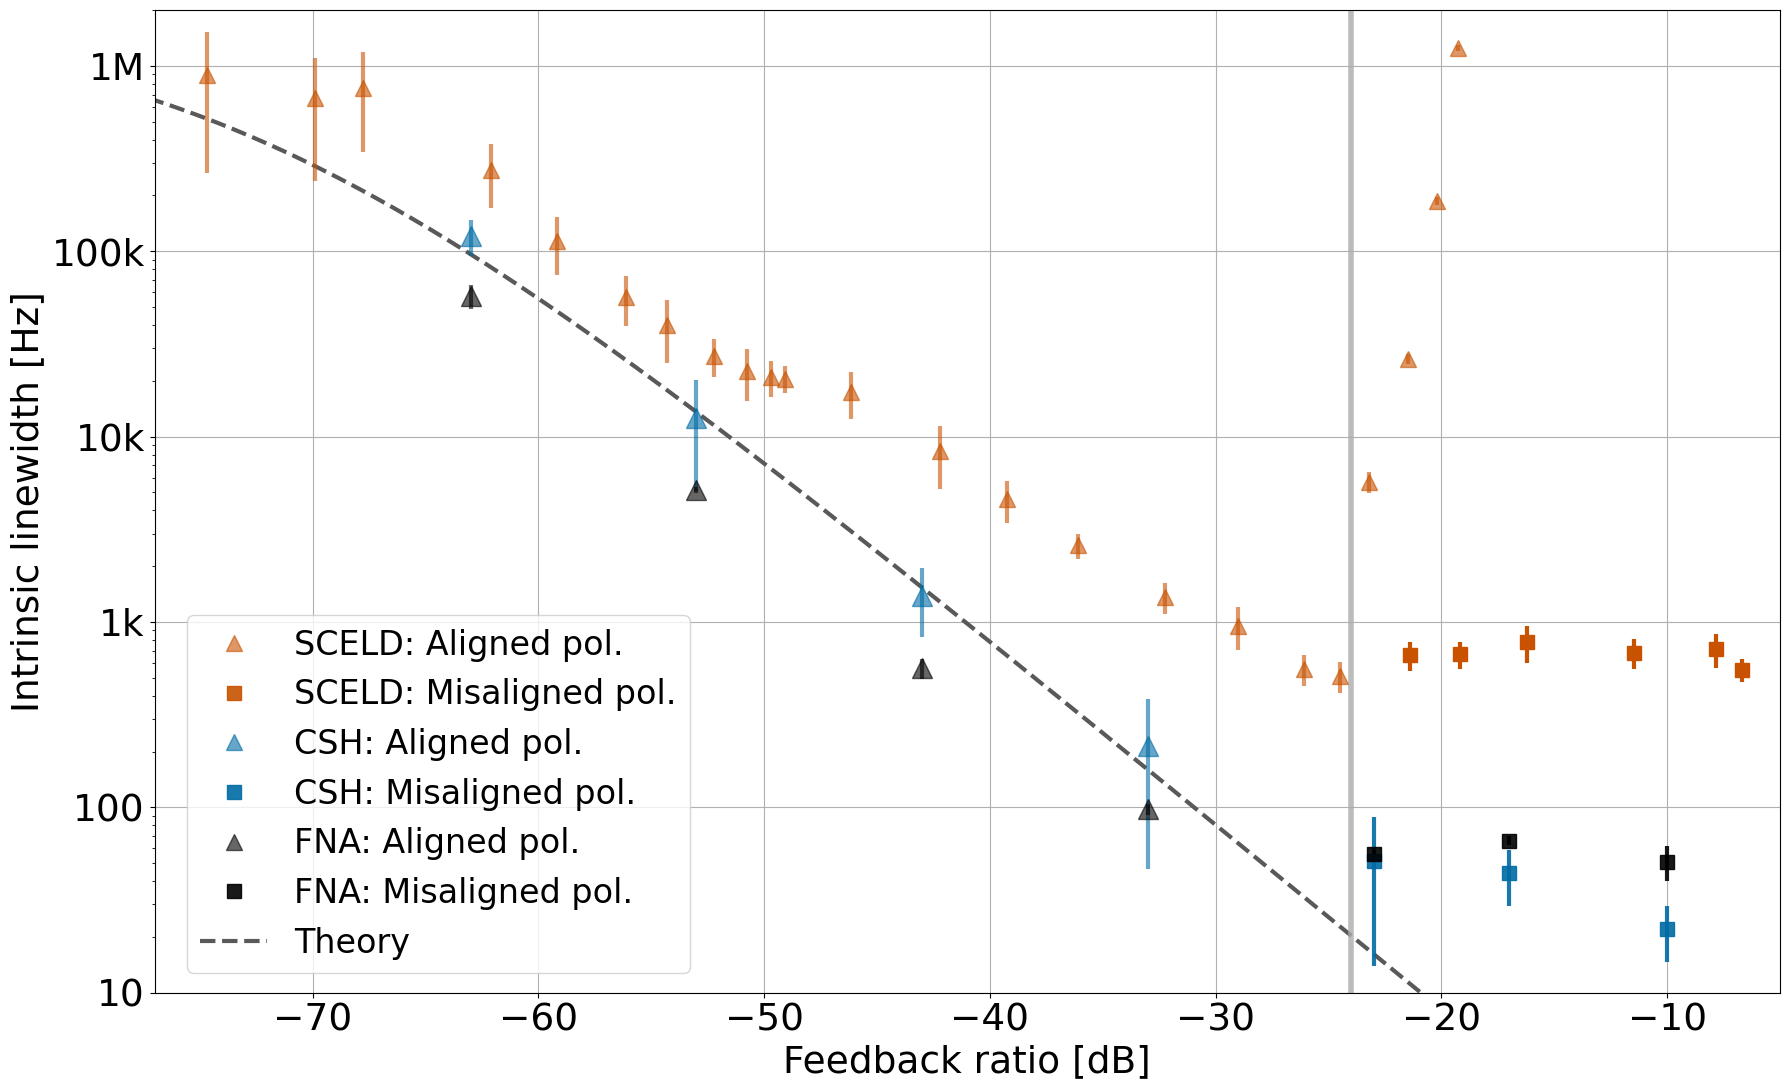

In [67]:
fbs, lw_mean, lw_std = plot_dataset(paths5)
plt.savefig(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\SPIE Prague 2025\Figures\linewidth_vs_fb.pdf",bbox_inches='tight')

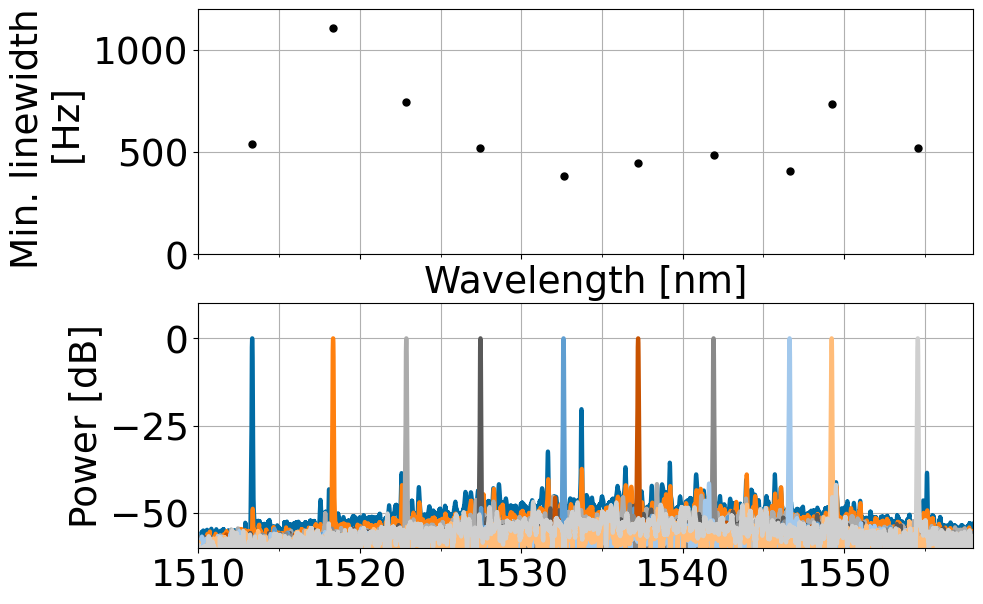

In [102]:
from matplotlib.ticker import MultipleLocator

wav_linewidths,wav_wavelengths = plot_wavelengths(paths6)
plt.savefig(r"O:\Tech_Photonics\Projects\Narrow Linewidth\MFB Chips\Chip 3 Feedback measurements\SPIE Prague 2025\Figures\wavelength_vs_linewidth.pdf",bbox_inches='tight')

Gain [mA]: [ 40.  60.  80. 110.]
Coh. collapse onset [dB]: [-50, -36, -29, -24]
Linewidth [Hz]: [20000.  2200.   840.   540.] 


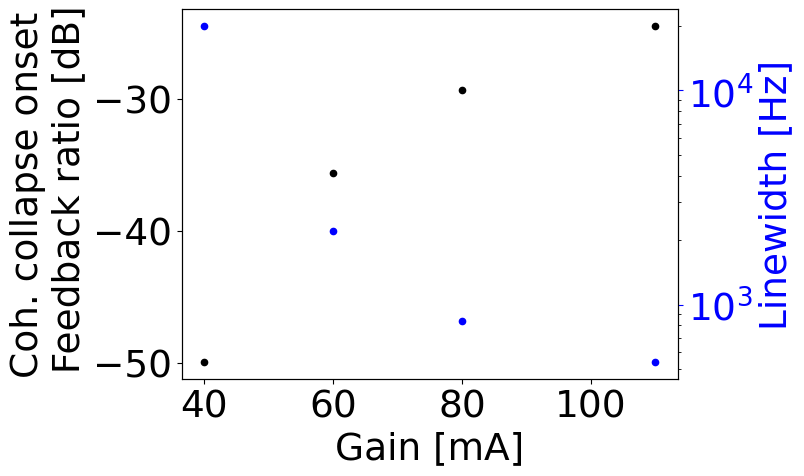

In [28]:
coh_collapse_data = np.loadtxt(r".\Data\coh_collapse_onset\README.txt",delimiter=',',comments="#")

gain = coh_collapse_data[:,0] #mA
output_power = coh_collapse_data[:,1]*40 #µW
feedback_power = coh_collapse_data[:,2] #µW
linewidth = coh_collapse_data[:,3] #Hz



fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

feedback_ratio = ratio_to_dB(feedback_power,output_power)

ax1.plot(gain, feedback_ratio,'k.')
ax2.plot(gain,linewidth,'b.')

ax2.set_yscale("log")  # Logarithmic scale for linewidth
ax2.set_ylabel("Linewidth [Hz]", color="blue")
ax2.tick_params(axis="y", colors="blue")
# ax2.spines["right"].set_color("blue")     

ax1.set(ylabel=('Coh. collapse onset\n Feedback ratio [dB]'))
ax1.set(xlabel=('Gain [mA]'))

print(f'Gain [mA]: {gain}\nCoh. collapse onset [dB]: {[int(round(number,0)) for number in feedback_ratio]}\nLinewidth [Hz]: {linewidth} ')